In [0]:
 '''
Note:
 1. If the loss or accuracy does not improve significantly every epoch, we need to adjust the learning rate
 2. If the accuracy is low, or the loss is high, we can try to add another convolutional layer, and each layer should double the output from previous layer
    using a smaller kernel size can capture more sophisticated feature, and padding can complement the edge of image after convolution
 3. To reduce overfitting, we add dropout layers and use data augmentation technique
'''

In [0]:
!pip install torch torchvision

In [0]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [43]:
transform_train = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2), shear =(-10, 10)),
    transforms.RandomRotation(degrees=10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

training_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
print(len(training_dataset))
testing_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
print(len(testing_dataset))

training_loader = torch.utils.data.DataLoader(dataset = training_dataset, batch_size=100, shuffle=True)
testing_loader = torch.utils.data.DataLoader(dataset = testing_dataset, batch_size=100, shuffle=False)

Files already downloaded and verified
50000
Files already downloaded and verified
10000


In [0]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1,2,0)
  image = image*(0.5,0.5,0.5)+(0.5,0.5,0.5)
  return image

In [0]:
classes = ['plane', 'car', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

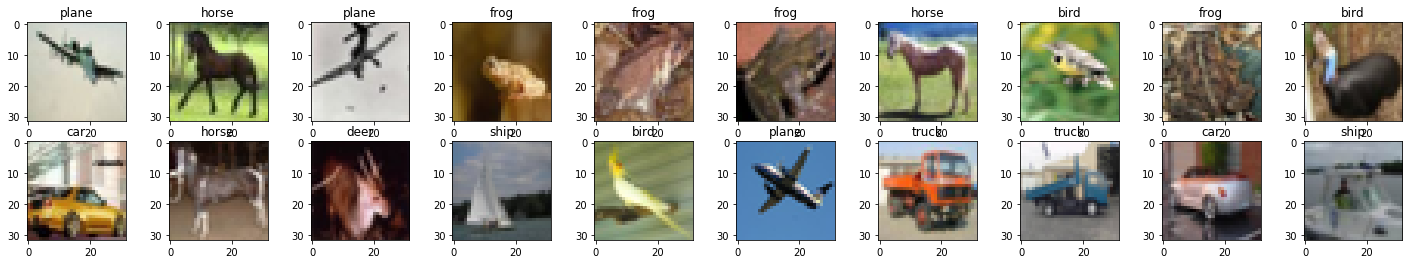

In [20]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25,4))

for idx in range(20):
  im = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  im.set_title(classes[labels[idx].item()])

In [0]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        #1st argument:  number of channel of input image(in this case, colored image has 3 channel)
        #2nd argument:  number of output layers
        #3rd argument:  kernel size
        #4th argument:  stride length
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)#padding is to complement the edge part
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        
        # in the first convolutional layer, the size of feature map is 32*32(because of padding), and there are 16 feature maps
        # in the first pooling layer, the size decrease by 2 and becomes 16*16, and there are still 16 feature maps
        # in the second convolutional layer, the size of feature map is 16*16, and there are 32 feature maps
        # in the second pooling layer, the size decrease by 2 and becomes 8*8, and there are still 32 maps
        # in the third conv layer, the size of feature map is 8*8, and there are 64 feature maps
        # in the third pooling layer, the size decrease by 2 and becomes 4*4, and there are still 64 feature maps
        # that's why there are 4*4*64 inputs for the fully connected layer
        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500 ,10)
        
        #dropout layer is usually used in layers with many parameters, becuase it's more likely to overfit
        self.dropout1 = nn.Dropout(0.5)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2) #2, 2 is the dimension of pooling kernel
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [96]:
model = LeNet()
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5)
)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [99]:
epochs = 10
losses = []
accuracy = []
val_losses = []
val_accuracy = []

for i in range(epochs):
    epoch_loss = 0.0
    epoch_acc = 0.0
    val_loss = 0.0
    val_acc = 0.0
    counter =1
    #for loop 600 times, which is the number of batches, 
    #批量训练， 每次训练100张图片，不需要循环，一块input
    for images, labels in training_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model.forward(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss +=loss.item()
        
        _, preds = torch.max(outputs, 1)
        epoch_acc += torch.sum(preds==labels.data)
    else:
        with torch.no_grad():
            for images, labels in testing_loader:
                images = images.to(device)
                labels = labels.to(device)
                val_outputs = model.forward(images)
                loss2 = criterion(val_outputs, labels)
                
                val_loss += loss2
                _, val_preds = torch.max(val_outputs, 1)
                val_acc += torch.sum(val_preds==labels.data)
                
        avg_epoch_loss = epoch_loss/500
        #loss是按照每个batch计算的, 而accuracy是按照每个image计算的, 所以loss/(number of batches),accuracy/(number of images)
        #直接除len是因为training_loader的batch_size为100
        #如果batch_size不是100， 改为len(training_loader.dataset)或者 len(training_dataset)
        avg_epoch_acc = epoch_acc.float()/len(training_loader.dataset)
        print('epoch:',i, 'loss:{:.4f}'.format(avg_epoch_loss), 'accuracy:{:.4f}'.format(avg_epoch_acc))
        losses.append(avg_epoch_loss)
        accuracy.append(avg_epoch_acc)
        
        avg_val_loss = val_loss/100
        avg_val_acc = val_acc.float()/len(testing_loader.dataset)
        print('epoch:',i, 'val_loss:{:.4f}'.format(avg_val_loss), 'val_accuracy:{:.4f}'.format(avg_val_acc))
        val_losses.append(avg_val_loss)
        val_accuracy.append(avg_val_acc)

epoch: 0 loss:1.1879 accuracy:0.5776
epoch: 0 val_loss:1.0890 val_accuracy:0.6191
epoch: 1 loss:1.1132 accuracy:0.6061
epoch: 1 val_loss:1.0445 val_accuracy:0.6379
epoch: 2 loss:1.0573 accuracy:0.6264
epoch: 2 val_loss:0.9491 val_accuracy:0.6707
epoch: 3 loss:1.0178 accuracy:0.6424
epoch: 3 val_loss:0.9323 val_accuracy:0.6730
epoch: 4 loss:0.9784 accuracy:0.6559
epoch: 4 val_loss:0.9206 val_accuracy:0.6797
epoch: 5 loss:0.9496 accuracy:0.6658
epoch: 5 val_loss:0.8812 val_accuracy:0.6943
epoch: 6 loss:0.9349 accuracy:0.6708
epoch: 6 val_loss:0.8506 val_accuracy:0.7050
epoch: 7 loss:0.9064 accuracy:0.6815
epoch: 7 val_loss:0.8836 val_accuracy:0.6886
epoch: 8 loss:0.8913 accuracy:0.6874
epoch: 8 val_loss:0.8024 val_accuracy:0.7232
epoch: 9 loss:0.8710 accuracy:0.6944
epoch: 9 val_loss:0.8164 val_accuracy:0.7147


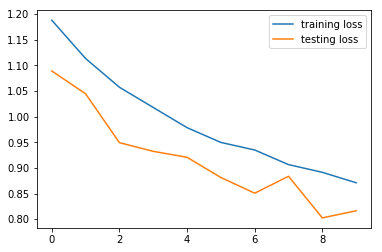

In [100]:
plt.plot(losses, label='training loss')
plt.plot(val_losses, label='testing loss')
plt.legend()

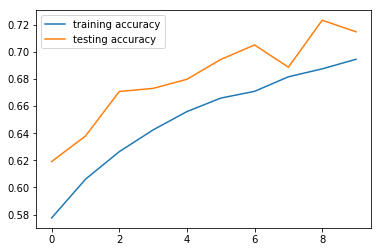

In [101]:
plt.plot(accuracy, label='training accuracy')
plt.plot(val_accuracy, label='testing accuracy')
plt.legend()

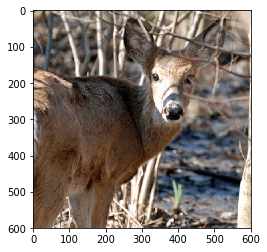

In [102]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://www.outsideonline.com/sites/default/files/styles/img_600x600/public/migrated-images_parent/migrated-images_85/venison-dc-kitchen_fe.jpg?itok=z0_-UY8S'
response = requests.get(url, stream=True)
img = Image.open(response.raw)
plt.imshow(img)

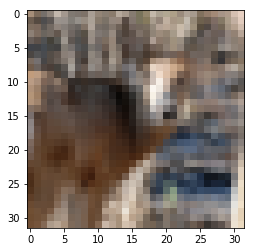

In [103]:
img=transform(img)
plt.imshow(im_convert(img))

In [104]:
img = img.to(device).unsqueeze(0)
output = model.forward(img)
number, pred = torch.max(output, 1)#the result tuple of two output tensors (max, max_indices), using only output can not give indices
#print(pred, number)
print(classes[pred.item()], number)

deer tensor([1.3222], grad_fn=<MaxBackward0>)


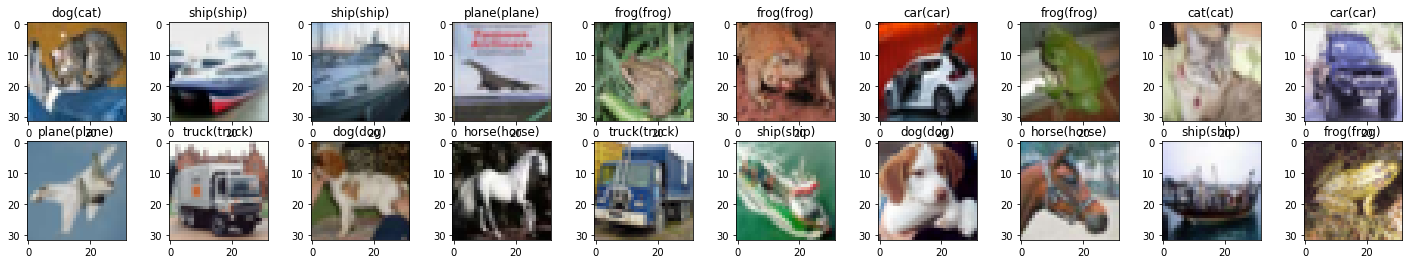

In [90]:
dataiter = iter(testing_loader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model.forward(images)
_, preds = torch.max(output, 1)
                       
plt.figure(figsize=(25,4))

for idx in range(20):
  im = plt.subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  im.set_title('{}({})'.format(classes[preds[idx].item()], classes[labels[idx]]))